In [2]:
import git

repo = git.Repo('.', search_parent_directories=True)
repo_path = repo.working_tree_dir

In [3]:
repo_path

'c:\\Users\\Johnk\\Documents\\PhD\\Quantum Computing Code\\Quantum-Computing'

In [4]:
import numpy as np
import pandas as pd
import json
import os
import pennylane as qml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
def get_data(path, cutoffs, potentials, is_de, debug=False, converged_only=True):

    evals = {potential: [] for potential in potentials}
    evals_min = {potential: [] for potential in potentials}
    evals_max = {potential: [] for potential in potentials}

    times = {potential: [] for potential in potentials}
    lower_std = {potential: [] for potential in potentials}
    upper_std = {potential: [] for potential in potentials}

    delta_e = {potential: [] for potential in potentials}

    for potential in potentials:
        for cutoff in cutoffs:

            file_path = os.path.join(path, potential, f"{potential}_{cutoff}.json")
            
            with open(file_path, 'r') as f:
                data = json.load(f)

            converged_indices = [i for i, success in enumerate(data['success']) if success]

            run_times = data['run_times']

            if is_de:
                evals_d = data['num_evaluations']
            else:
                evals_d = data['num_iters']
                        
            
            time_series = np.array([pd.Timedelta(t).seconds for t in run_times])
            mean_vqe_time = np.mean(time_series)
            times[potential].append(mean_vqe_time)

            #std_vqe_time = np.std(t_sec)
            ustd = np.std(time_series[time_series >= mean_vqe_time], ddof=1)
            lstd = np.std(time_series[time_series <= mean_vqe_time], ddof=1)
            lower_std[potential].append(lstd)
            upper_std[potential].append(ustd)

            mean_evals = np.mean(evals_d)
            min_evals = np.min(evals_d)
            max_evals = np.max(evals_d)
            evals[potential].append(mean_evals)
            evals_min[potential].append(min_evals)
            evals_max[potential].append(max_evals)
            
            exact_min_e = np.min(data['exact_eigenvalues'])
            
            if converged_only:
                median_e = np.median([data['results'][i] for i in converged_indices])
            else:
                median_e = np.median(data['results'])

            delta_median_e = (abs(exact_min_e - median_e)) 
            delta_e[potential].append(delta_median_e)

            if debug: print(potential, cutoff, delta_median_e)

    return times, lower_std, upper_std, delta_e, evals, evals_min, evals_max

In [14]:
def plot(data_paths, cutoffs, potentials, debug=False, converged_only=True):

    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
    for label, path in data_paths:

        if debug:
            print("#################################################")
            print(label)

        is_de = True if "DE" in label else False
        times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, cutoffs, potentials, is_de=is_de, debug=debug, converged_only=converged_only)

        for i, potential in enumerate(potentials):
            axs = axes[0, i]
            axs.plot(cutoffs, delta_e[potential], marker='^', label=label)
            axs.set_title(f'{potential}')
            axs.set_yscale('symlog', linthresh=1)
            axs.grid(True)
            
            if i == 0:
                axs.set_ylabel('|$E_{exact}$ - $E_{median}$|')
                axs.legend(loc='upper left', fontsize=8)
            else:
                axs.tick_params(axis='y', left=False, right=False, labelleft=False)
        
            axs.tick_params(axis='x', bottom=False, top=False, labelbottom=False)

        for i, potential in enumerate(potentials):
            axs = axes[1, i]
            axs.errorbar(cutoffs, times[potential], yerr=[lower_std[potential], upper_std[potential]],marker='^', capsize=5, label=label)
            
            axs.set_yscale('symlog', linthresh=1)
            axs.grid(True)

            if i == 0:
                axs.set_ylabel('Mean Time (s)')
            else:
                axs.tick_params(axis='y', left=False, right=False, labelleft=False)

            axs.tick_params(axis='x', bottom=True, top=False, labelbottom=True)

    axes[1, 1].set_xlabel('$\\Lambda$')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_xticks(cutoffs)
    axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axes[1, 0].xaxis.set_minor_locator(ticker.NullLocator())

    plt.tight_layout(pad=0.5)
    plt.show()


In [29]:
pl_de_paths = [("PL-DE-RA", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\Files - RA")),
              ("PL-DE-ADAPT", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT")),
              ("PL-DE-OP-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-OP-10k")),
              ("PL-DE-OP-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-Op-100k")),
              ("PL-DE-OP-Overlap-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-Overlap"))]
              

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


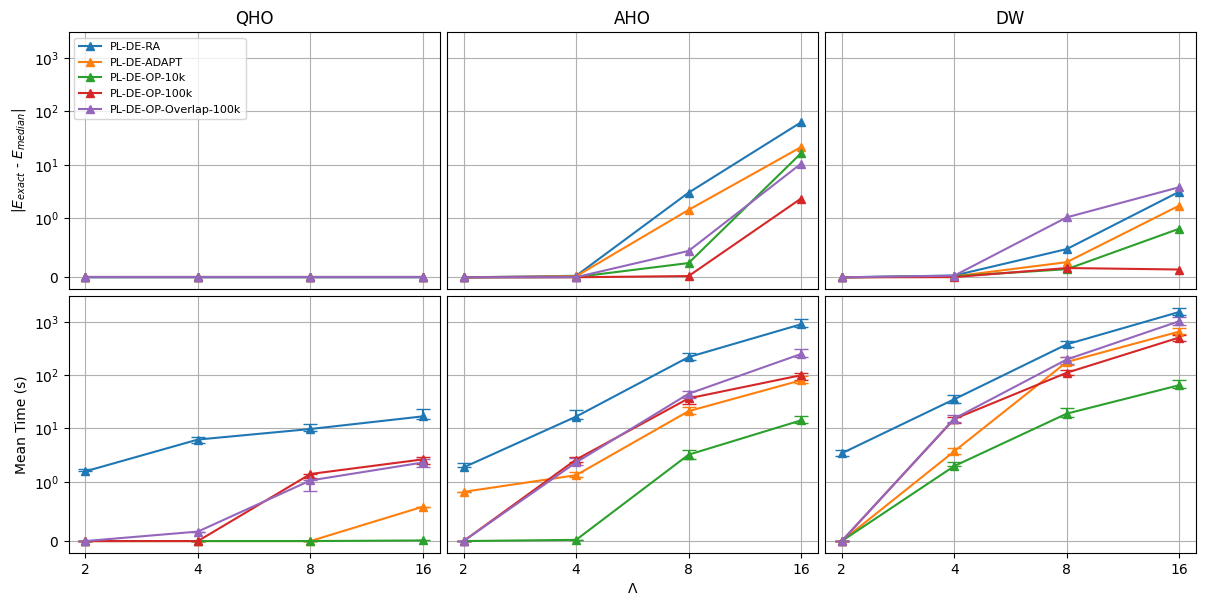

In [30]:
cutoffs = [2,4,8,16]
potentials = ['QHO', 'AHO', 'DW']
plot(pl_de_paths, cutoffs, potentials)

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


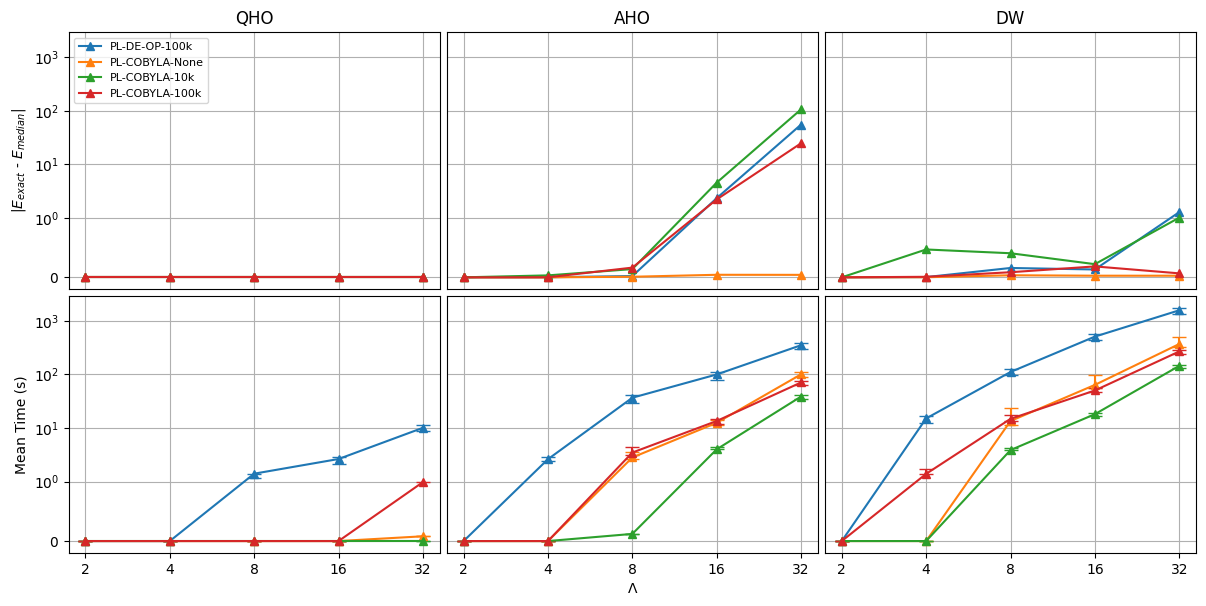

In [50]:
cutoffs = [2,4,8,16, 32]
potentials = ['QHO', 'AHO', 'DW']
pl_cob_paths = [("PL-DE-OP-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-Op-100k")),
                ("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\None")),
                ("PL-COBYLA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\10000")),
                ("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\100000"))]

plot(pl_cob_paths, cutoffs, potentials, debug=False)
              

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


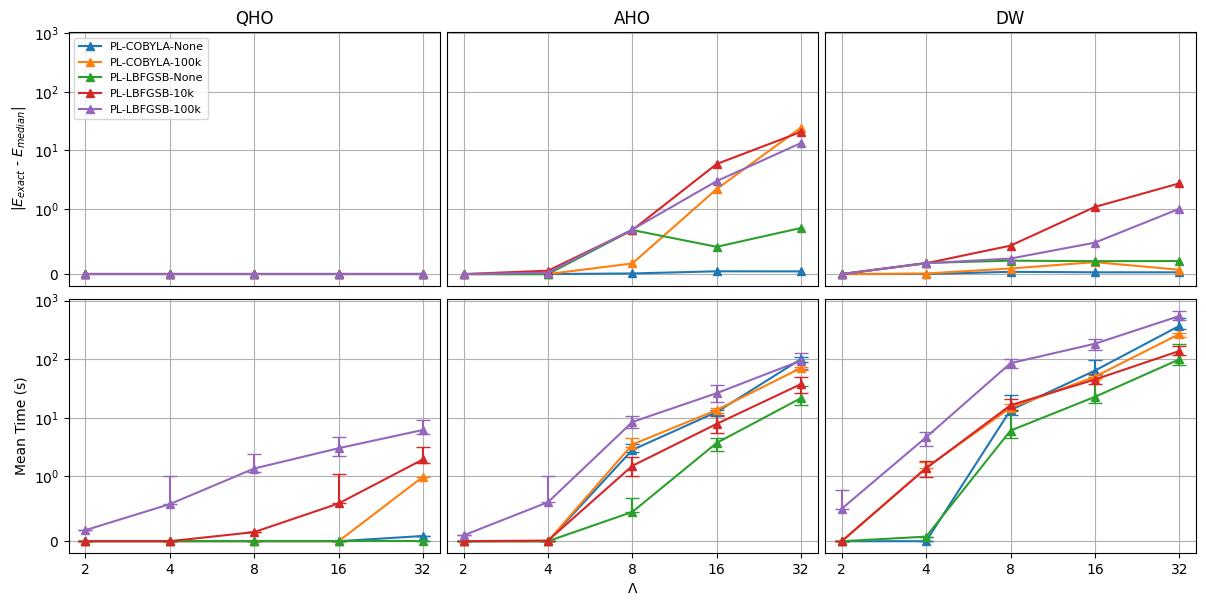

In [45]:
cutoffs = [2,4,8,16, 32]
potentials = ['QHO', 'AHO', 'DW']
pl_lb_paths = [("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\None")),
               ("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\100000")),
               ("PL-LBFGSB-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\default.qubit\None")),
               ("PL-LBFGSB-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\default.qubit\10000")),
               ("PL-LBFGSB-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\default.qubit\100000"))
                ]

plot(pl_lb_paths, cutoffs, potentials, debug=False, converged_only=True)
              

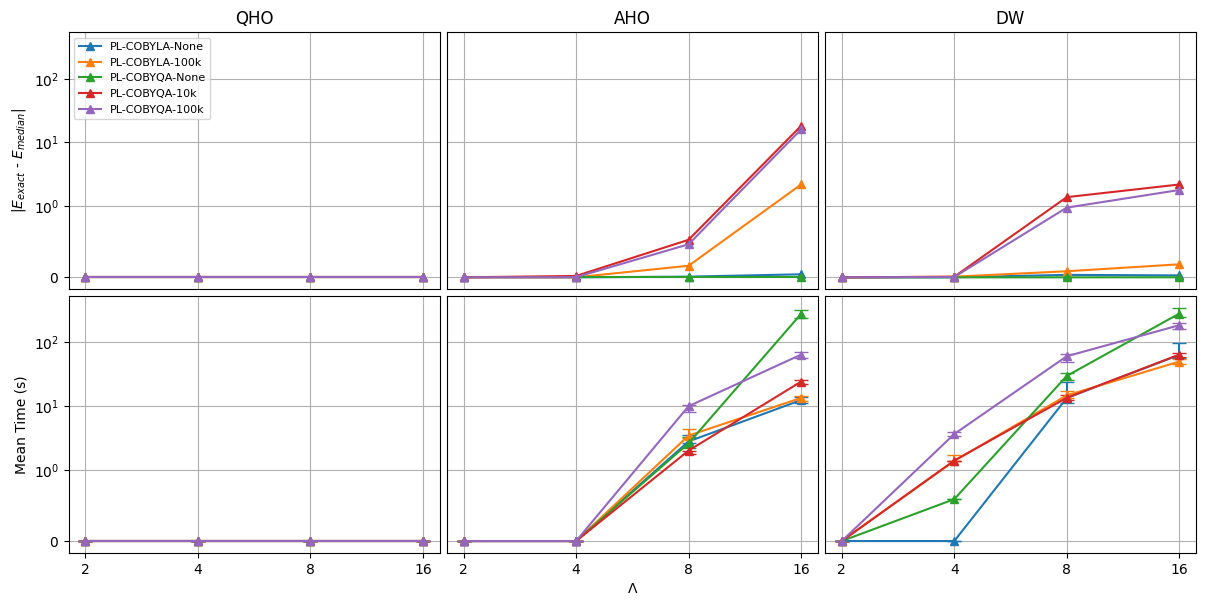

In [7]:
cutoffs = [2,4,8,16]
potentials = ['QHO', 'AHO', 'DW']
pl_lb_paths = [("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\Files\None")),
               ("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\Files\100000")),
               ("PL-COBYQA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\Files\None")),
               ("PL-COBYQA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\Files\10000")),
               ("PL-COBYQA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\Files\100000"))
                ]

plot(pl_lb_paths, cutoffs, potentials, debug=False, converged_only=True)
              

c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


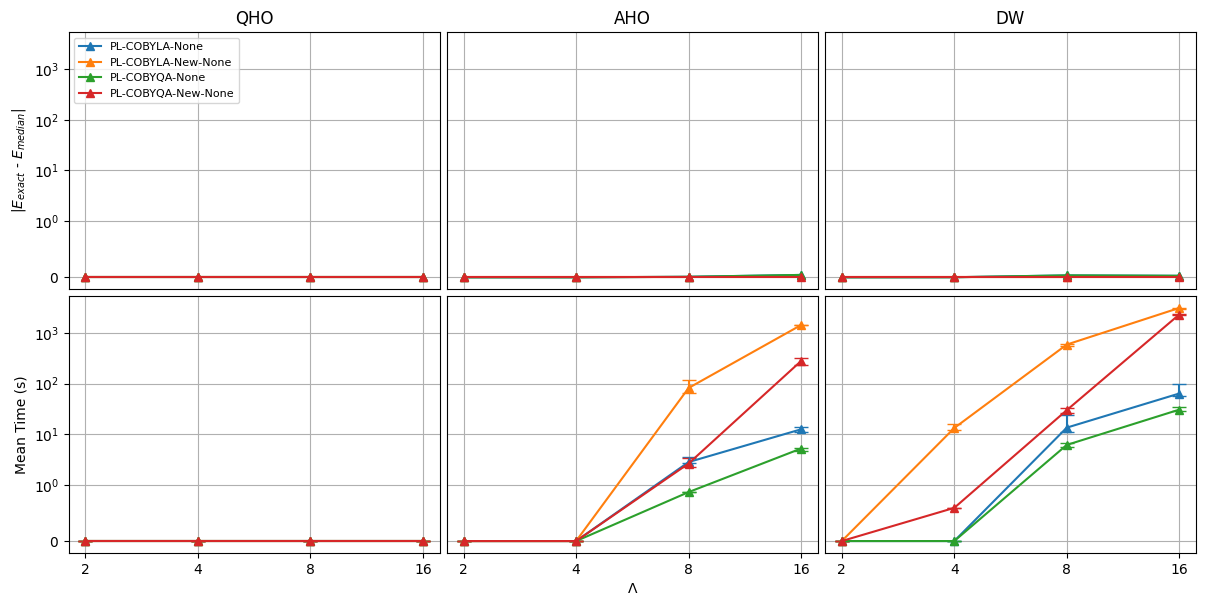

In [30]:
cutoffs = [2,4,8,16]
potentials = ['QHO', 'AHO', 'DW']
pl_lb_paths = [("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesOld\None")),
               ("PL-COBYLA-New-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesNew\None")),
               ("PL-COBYQA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesOld\None")),
               ("PL-COBYQA-New-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNew\None"))
                ]

plot(pl_lb_paths, cutoffs, potentials, debug=False, converged_only=True)
              

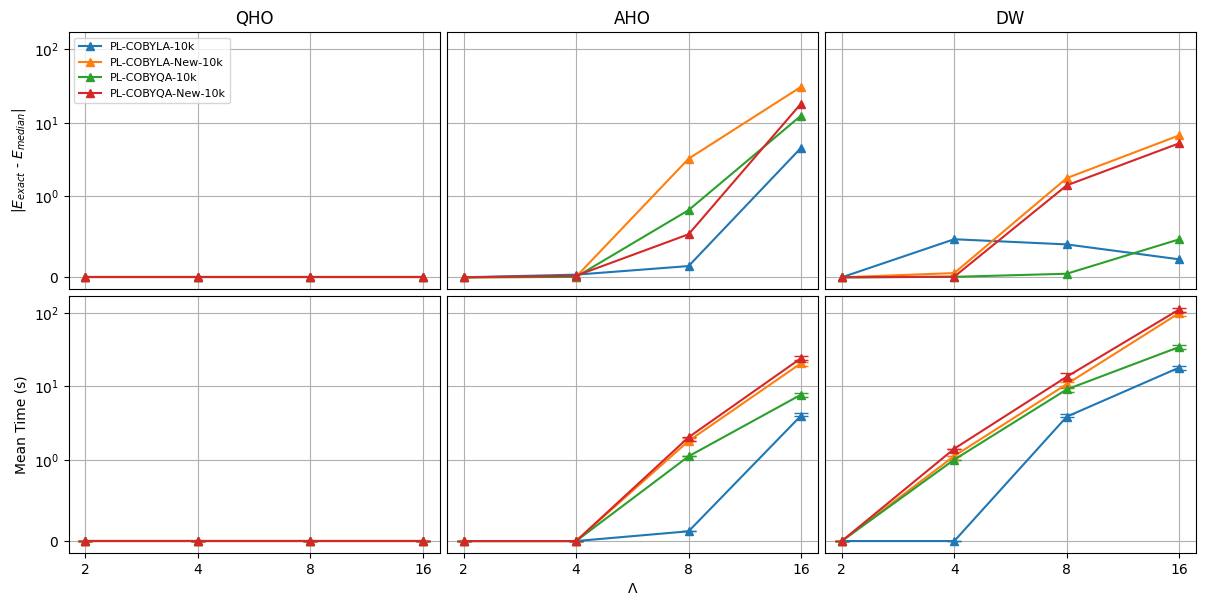

In [27]:
cutoffs = [2,4,8,16]
potentials = ['QHO', 'AHO', 'DW']
pl_lb_paths = [("PL-COBYLA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesOld\10000")),
               ("PL-COBYLA-New-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesNew\10000")),
               ("PL-COBYQA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesOld\10000")),
               ("PL-COBYQA-New-10k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNew\10000"))
                ]

plot(pl_lb_paths, cutoffs, potentials, debug=False, converged_only=True)
              

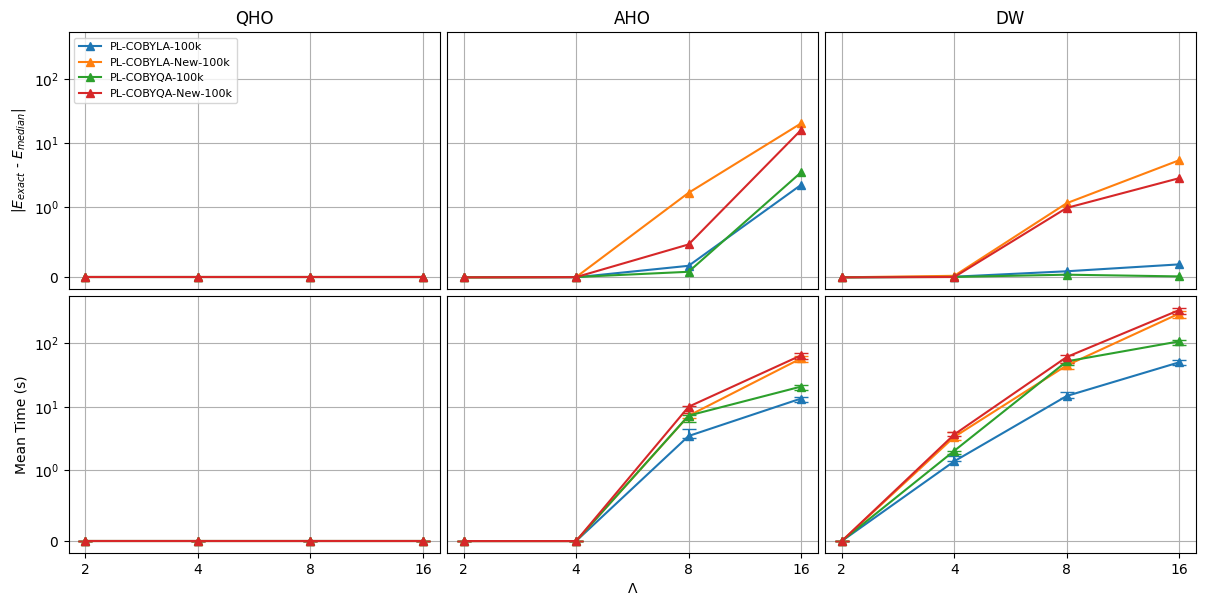

In [24]:
cutoffs = [2,4,8,16]
potentials = ['QHO', 'AHO', 'DW']
pl_lb_paths = [("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesOld\100000")),
               ("PL-COBYLA-New-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesNew\100000")),
               ("PL-COBYQA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesOld\100000")),
               ("PL-COBYQA-New-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNew\100000"))
                ]

plot(pl_lb_paths, cutoffs, potentials, debug=False, converged_only=True)
              

#################################################
PL-COBYLA-None
QHO 2 0.0
QHO 4 2.220446049250313e-16
QHO 8 2.7755575615628914e-16
QHO 16 4.440892098500626e-16
QHO 32 3.885780586188048e-16
AHO 2 1.1102230246251565e-16
AHO 4 9.43689570931383e-16
AHO 8 0.009593949500619488
AHO 16 0.04270978233607175
AHO 32 0.04153662443167662
DW 2 3.3306690738754696e-16
DW 4 0.0015379896792760972
DW 8 0.0345083497707247
DW 16 0.027232708849012743
DW 32 0.027199700621480916
#################################################
QK-COBYLA-Tut-None
QHO 2 0.0
QHO 4 1.1102230246251565e-16
QHO 8 0.0
QHO 16 4.440892098500626e-16
QHO 32 3.885780586188048e-16
AHO 2 1.1102230246251565e-16
AHO 4 0.03053447398167136
AHO 8 2.141968595759825
AHO 16 22.035644788853222
AHO 32 80.8613692992622
DW 2 0.0
DW 4 0.21331667386967557
DW 8 1.5279296243713685
DW 16 3.323426170002626
DW 32 6.502205201362571
#################################################
QKPL-COBYLA-None
QHO 2 0.0
QHO 4 1.1102230246251565e-16
QHO 8 0.0
QHO 16 4.4408

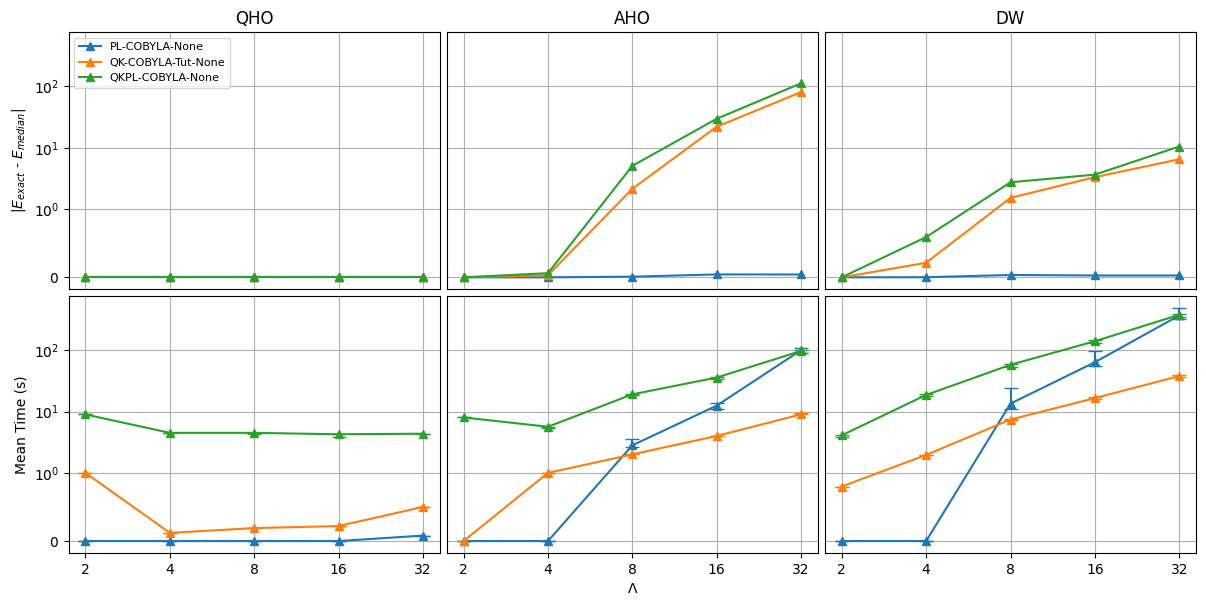

: 

In [11]:
cutoffs = [2,4,8,16, 32]
potentials = ['QHO', 'AHO', 'DW']
qk_paths = [#("PL-DE-OP-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-Op-100k")),
            ("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\None")),
            #("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\100000")),
            #("QK-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\None")),
            #("QK-COBYLA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\10000")),
            #("QK-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\100000")),
            ("QK-COBYLA-Tut-None", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\QK-Tutorial\None")),
            ("QKPL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\qiskit-aer\None"))
            ]

plot(qk_paths, cutoffs, potentials, debug=True, converged_only=True)
              

#################################################
PL-COBYLA-None
AHO 2 1.1102230246251565e-16
AHO 4 9.43689570931383e-16
AHO 8 0.009593949500619488
AHO 16 0.04270978233607175
AHO 32 0.04153662443167662
#################################################
QK-COBYLA-None
AHO 2 1.1102230246251565e-16
AHO 4 0.013297095093632694
AHO 8 2.659206580245174
AHO 16 22.505571571317752
AHO 32 60.82599293855871
#################################################
QKPL-COBYLA-None
AHO 2 1.1102230246251565e-16
AHO 4 0.060700901620271475
AHO 8 5.075711276481636
AHO 16 29.738848191247264
AHO 32 112.55021595445788


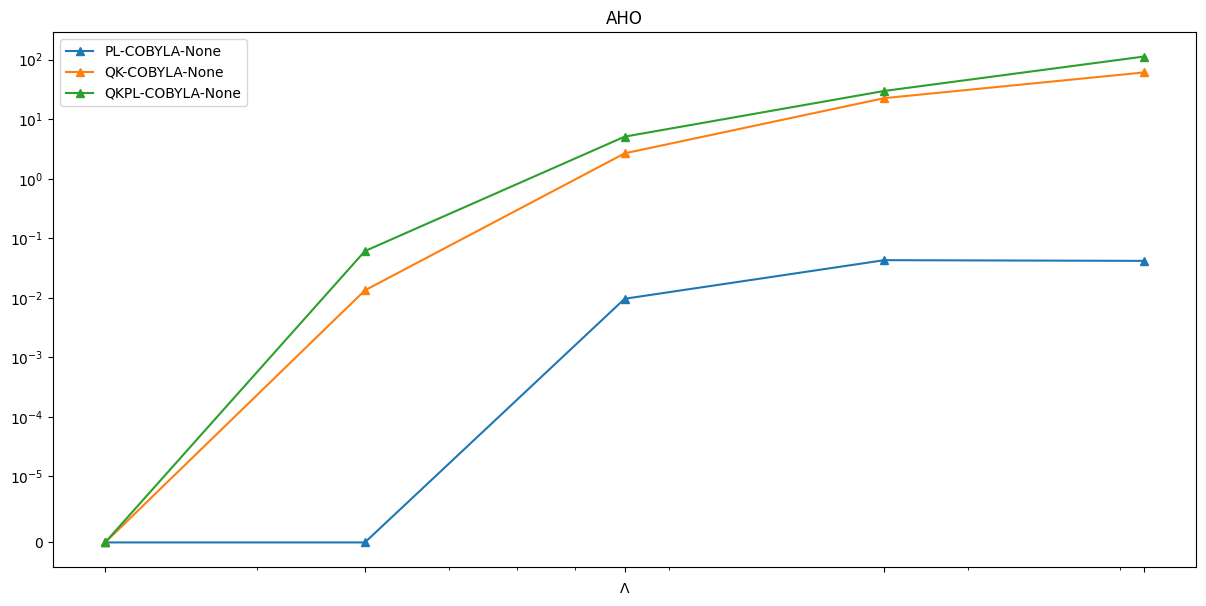

In [51]:
cutoffs = [2,4,8,16, 32]
potentials = ['AHO']
qk_paths = [#("PL-DE-OP-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\Differential Evolution\PauliDecomp\VQE\FilesADAPT-Op-100k")),
            ("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\None")),
            #("PL-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\Files\100000")),
            ("QK-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\None")),
            #("QK-COBYLA-10k", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\10000")),
            #("QK-COBYLA-100k", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\Files\100000")),
            #("QK-COBYLA-Tut-None", os.path.join(repo_path, r"SUSY\SUSY QM\Qiskit\COBYLA\QK-Tutorial\None")),
            ("QKPL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\qiskit-aer\None")),
            #("PL-LBFGSB-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\default.qubit\None")),
            #("QKPL-LBFGSB-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\L-BFGS-B\PauliDecomp\qiskit.aer\FilesGrad\None"))
            ]

plt.figure(figsize=(12, 6))
for label, path in qk_paths:

    print("#################################################")
    print(label)

    is_de = True if "DE" in label else False
    times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, cutoffs, potentials, is_de=is_de, debug=True, converged_only=True)

    for i, potential in enumerate(potentials):
        plt.plot(cutoffs, delta_e[potential], marker='^', label=label)
        

plt.title(f'{potential}')
plt.xlabel('$\\Lambda$')
plt.yscale('symlog', linthresh=1e-5)
plt.xscale('log')
plt.xticks(cutoffs)
plt.tight_layout(pad=0.5)
plt.legend()
plt.show()

#################################################
PL-COBYLA-None
QHO 2 0.0
QHO 4 2.220446049250313e-16
QHO 8 2.7755575615628914e-16
QHO 16 4.440892098500626e-16
#################################################
PL-COBYLA-New-None
QHO 2 0.0
QHO 4 1.1102230246251565e-16
QHO 8 0.0
QHO 16 4.440892098500626e-16
#################################################
PL-COBYQA-None
QHO 2 0.0
QHO 4 1.1102230246251565e-16
QHO 8 0.0
QHO 16 4.440892098500626e-16
#################################################
PL-COBYQA-New-None
QHO 2 0.0
QHO 4 1.1102230246251565e-16
QHO 8 0.0
QHO 16 4.440892098500626e-16


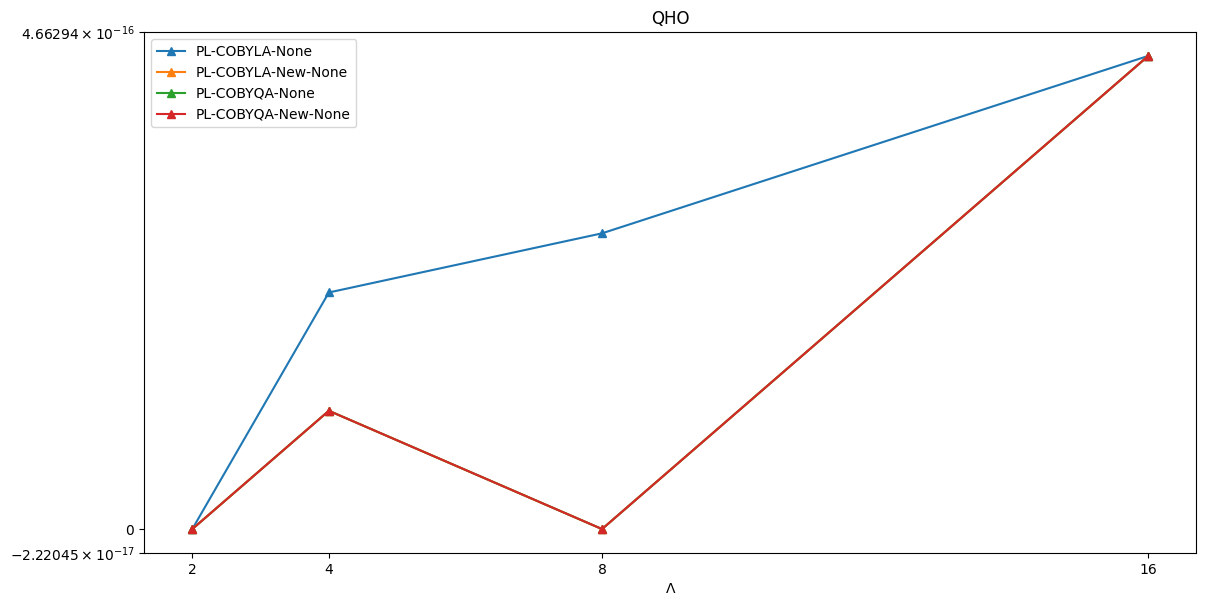

In [31]:
cutoffs = [2,4,8,16]
potentials = ['QHO']

pl_lb_paths = [("PL-COBYLA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesOld\None")),
               ("PL-COBYLA-New-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYLA\PauliDecomp\VQE\FilesNew\None")),
               ("PL-COBYQA-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesOld\None")),
               ("PL-COBYQA-New-None", os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\VQE\FilesNew\None"))
                ]             


plt.figure(figsize=(12, 6))
for label, path in pl_lb_paths:

    print("#################################################")
    print(label)

    is_de = True if "DE" in label else False
    times, lower_std, upper_std, delta_e, evals, evals_min, evals_max = get_data(path, cutoffs, potentials, is_de=is_de, debug=True, converged_only=True)

    for i, potential in enumerate(potentials):
        plt.plot(cutoffs, delta_e[potential], marker='^', label=label)
        

plt.title(f'{potential}')
plt.xlabel('$\\Lambda$')
plt.yscale('symlog', linthresh=1e-5)
#plt.xscale('log')
plt.xticks(cutoffs)
plt.tight_layout(pad=0.5)
plt.legend()
plt.show()